In [2]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
from scipy import stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [4]:
model_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\model_vars_data_n.csv',index_col=0)

test_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\test_vars_data_n.csv',index_col=0)

price_train = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_train.csv',index_col=0)

price_test = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_test.csv',index_col=0)

In [5]:
# list(model_vars_data.columns) 
model_vars_data = model_vars_data.drop(['MoSold','MSSubClass','LotArea'], axis = 1)
test_vars_data = test_vars_data.drop(['MoSold','MSSubClass','LotArea'], axis = 1) 
#there is a transformed version of LotArea


In [6]:
# Fucntion returns dictionary

def regx3(
model=  None,
x_train = None,
x_test = None,
y_train = None,
y_test =  None,
params = None,
cv_ = 5,
linear_reg = True,
tree_based = False):
######################################
#########################################

    features = list(x_train.columns)

    ss = StandardScaler()
    x_train = pd.DataFrame(ss.fit_transform(x_train), columns = features)
    x_test = pd.DataFrame(ss.fit_transform(x_test), columns = features)

    #     print('train ',x_train.head())
    #     print(' ')
    #     print('test ', x_test.head())


    gs = GridSearchCV(model, params, cv=cv_, return_train_score=True, refit=True)
    gs.fit(x_train,y_train)
    gs.best_params_

    reg_dict = {}
    model= gs.best_estimator_
    reg_dict['mod'] = model
    ###################################    

    print('best params: ',gs.best_params_)
    reg_dict['best params'] = gs.best_params_

    print('score: ',gs.score(x_train,y_train))
    reg_dict['score'] = gs.score(x_train,y_train)

    print('  ')
    print('test score: ',gs.score(x_test,y_test))
    reg_dict['test score'] = gs.score(x_test,y_test)

    if linear_reg:
        adj_r2 = 1-(1-gs.score(x_train,y_train))*(x_train.shape[0] - 1) / (x_train.shape[0] - x_train.shape[1] - 1)
        print('adj_r2: ', adj_r2)
        reg_dict['adj_r2'] = adj_r2

        adj_r2_test = 1-(1-gs.score(x_test,y_test))*(x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1)
        print('  ')
        print('adj_r2_test: ',adj_r2_test)
        reg_dict['adj_r2_test'] = adj_r2_test

        print(' ')

    train_pred = gs.best_estimator_.predict(x_train)
    print('train RMSE: ' + str(mean_squared_error(train_pred,y_train)**0.5))
    print('  ')
    reg_dict['train RMSE'] = mean_squared_error(train_pred,y_train)**0.5

    test_pred = gs.best_estimator_.predict(x_test)
    print('test RMSE: ' + str(mean_squared_error(test_pred,y_test)**0.5))
    ###
    reg_dict['test RMSE'] = mean_squared_error(test_pred,y_test)**0.5

    if linear_reg:

        coefs = pd.Series(gs.best_estimator_.coef_, name = 'coef' )

        varnames = pd.Series(features, name = 'features')

        pd.set_option('display.max_rows', None) # or 1000.

        abs_coefs = pd.Series(np.abs(coefs),name = 'abs_val')

        coefs_ = pd.concat([varnames,coefs, abs_coefs], axis=1)

        #return:
        model_importances = coefs_.sort_values(by=['abs_val'], ascending=False)
        model_importances.index=(range(model_importances.shape[0]))
        model_importances
        reg_dict['model_importances'] = model_importances

        print(model_importances)
        print(' ')

    elif tree_based:
        pd.set_option('display.max_rows', None) # or 1000.

        #return
        varnames = pd.Series(features, name = 'features')

        importances_ = pd.Series(model.feature_importances_, name = 'importances')

        df = pd.concat([varnames,importances_], axis=1)

        model_importances = df.sort_values(by=['importances'], ascending=False)

        model_importances.index=(range(model_importances.shape[0]))

        reg_dict['model_importances'] = model_importances



    #         model_importances = pd.Series(model.feature_importances_, index = features).sort_values(ascending=False)

        print(model_importances)


    if linear_reg:
        residuals = y_train - train_pred
        print('skewness: ',stats.skew(residuals))
        print(' ')
        sns.set_theme(style='darkgrid')
        sns.histplot(residuals, bins=20);

    print('model_importances.shape: ',model_importances.shape)
    
    return reg_dict


In [7]:
def to_keep(mod, amt):
    mod = mod['model_importances']
    keeps1 = mod.loc[mod['abs_val'] > amt,['features']]
    list_keeps1 = list(keeps1.features)
    return list_keeps1


remove due to mulicollinearity - see Correlations Analysis notebook

In [8]:
remove = ['log_first_FlrSF','BsmtFinSF1', 'BsmtUnfSF','yeo_GarageArea','GarageCars',
          'yeo_LotFrontage', 'BsmtFinSF2' ] #remove due to mulicollinearity #drop GarageYrBlt
#see Correlations Analysis notebook

In [9]:
keeps_set = set(model_vars_data.columns) - set(remove)
keeps_set
keeps = list(keeps_set)

best params:  {'alpha': 10, 'tol': 0.02}
score:  0.9496097341375433
  
test score:  0.9215648947470045
adj_r2:  0.9432433076230194
  
adj_r2_test:  0.8937510276360132
 
train RMSE: 0.08473246903162163
  
test RMSE: 0.10437838569305931
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.123269  0.123269
1                                          OverallQual  0.060783  0.060783
2                                      yeo_TotalBsmtSF  0.049772  0.049772
3                                           house_age_ -0.049669  0.049669
4                                          OverallCond  0.047115  0.047115
5                                    HouseStyle_1Story  0.041405  0.041405
6                                           bc_LotArea  0.038444  0.038444
7                                      MasVnrType_None  0.034800  0.034800
8                                             2ndFlrSF  0.030980  0.030980
9         Neigh

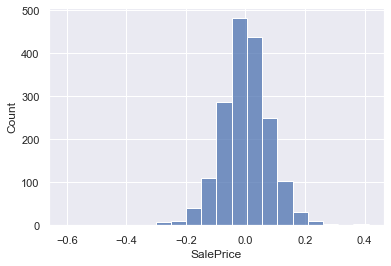

In [10]:
ridge1 = regx3(model= Ridge(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

<AxesSubplot:ylabel='Density'>

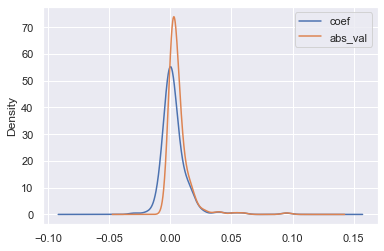

In [10]:
ridge1['model_importances'].plot.kde()

most of the features are between abs value 0.00 and 0.025 because after that the curve flattens out

chose 0.02 for below because that's where the graph begins to flatten out

<AxesSubplot:ylabel='Density'>

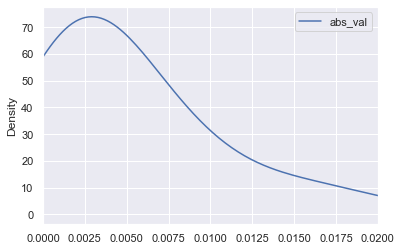

In [11]:
ridge1['model_importances'].plot.kde(y='abs_val',xlim=[0.0,0.02]) 

look at features less than 0.0025 see what they are and then potentially eliminate them. use 0.0025 because 0.0025 thar is where the graph turns.  look at the left side.

In [12]:
# ridge1['model_importances'].plot.hist(y='abs_val', xlim=[0.0,0.02],bins=50)

In [12]:
keeps = to_keep(ridge1,0.0025)

best params:  {'alpha': 10, 'tol': 0.02}
score:  0.6697337451991264
  
test score:  0.673956629009397
adj_r2:  0.6411549467946632
  
adj_r2_test:  0.5995222902945005
 
train RMSE: 0.21692451618192837
  
test RMSE: 0.21281048492022447
                                         features      coef   abs_val
0                                     OverallQual  0.015304  0.015304
1                                    bc_GrLivArea  0.014997  0.014997
2                                 yeo_TotalBsmtSF  0.012509  0.012509
3                                       ExterQual  0.011806  0.011806
4                                     KitchenQual  0.011757  0.011757
5                                     FireplaceQu  0.010434  0.010434
6                                        BsmtQual  0.010123  0.010123
7                                    TotRmsAbvGrd  0.010122  0.010122
8                                      Fireplaces  0.010028  0.010028
9                                        FullBath  0.009919  0.009

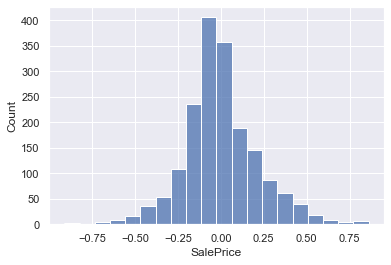

In [13]:
ridge2 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'tol':[0.02]},
cv_ = 3,
linear_reg = True,
tree_based = False)

In [16]:
keeps = to_keep(ridge2,0)  #increase alpha range

best params:  {'alpha': 50, 'tol': 0.02}
score:  0.29246959108883097
  
test score:  0.29593773303239346
adj_r2:  0.2312451437607469
  
adj_r2_test:  0.13520326050924225
 
train RMSE: 0.31750392011815365
  
test RMSE: 0.31272375255292506
                                         features          coef       abs_val
0                                     OverallQual  5.031022e-03  5.031022e-03
1                                    bc_GrLivArea  4.648609e-03  4.648609e-03
2                                       ExterQual  4.134022e-03  4.134022e-03
3                                     KitchenQual  4.027835e-03  4.027835e-03
4                                 yeo_TotalBsmtSF  4.011923e-03  4.011923e-03
5                                        BsmtQual  3.704408e-03  3.704408e-03
6                                        FullBath  3.458190e-03  3.458190e-03
7                                     GarageYrBlt  3.452112e-03  3.452112e-03
8                                     FireplaceQu  3.442898e

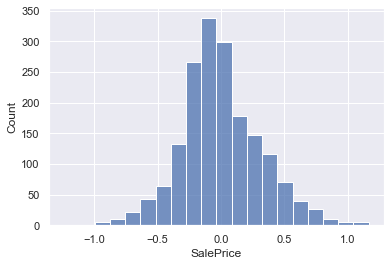

In [17]:
ridge3 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [18]:
keeps = to_keep(ridge2,0)

In [20]:
features4 = to_keep(ridge2,0)
dummies=[]
for f in features4:
    if model_vars_data[f].max() == 1:
        dummies.append(f)


dummy_drops = []
for feature in dummies:
    if round(model_vars_data[feature].mean(),2) < 0.05:
        dummy_drops.append(feature)
dummy_drops

['SaleCondition_Partial',
 'MSSubClass_160',
 'BldgType_Twnhs',
 'LandContour_HLS',
 'Electrical_FuseF',
 'MSSubClass_180',
 'Foundation_Slab',
 'MSSubClass_190',
 'RoofMatl_WdShngl',
 'BldgType_2fmCon',
 'Exterior1st_BrkFace',
 'Condition1_PosA',
 'Condition1_PosN',
 'SaleCondition_Family',
 'MSSubClass_75',
 'HouseStyle_SFoyer',
 'has_pool',
 'HouseStyle_2.5Unf',
 'Exterior2nd_BrkFace',
 'Exterior1st_Stucco',
 'HouseStyle_1.5Unf',
 'Condition2_Feedr',
 'Heating_Grav',
 'Exterior2nd_PreCast',
 'Exterior1st_PreCast',
 'Heating_Wall',
 'Exterior2nd_Wd Shng',
 'LandContour_Low',
 'MSZoning_RH',
 'RoofMatl_Membran',
 'Condition1_RRAn',
 'LotConfig_FR3',
 'LotConfig_FR2',
 'Exterior1st_CBlock',
 'Exterior2nd_ImStucc',
 'MSSubClass_85',
 'Exterior2nd_AsphShn',
 'Exterior2nd_Brk Cmn',
 'MSSubClass_150',
 'MoSold_11',
 'Foundation_Stone',
 'Foundation_Wood',
 'RoofStyle_Mansard',
 'Condition1_RRNn',
 'Exterior1st_CemntBd',
 'Neighborhood_SawyerW',
 'Exterior2nd_CmentBd',
 'Condition2_RRAn',
 

In [21]:
keep_set = set(features4) - set(dummy_drops)
keeps = list(keep_set)
keeps

['Exterior2nd_VinylSd',
 'MiscVal',
 'Neighborhood_Mitchel_NPkVill',
 'FireplaceQu',
 'GarageType_Detchd',
 'Exterior1st_Wd Sdng',
 'TotRmsAbvGrd',
 'house_age_',
 'years_since_remodeled_',
 'MoSold_5',
 'HouseStyle_2Story',
 'MasVnrType_Stone',
 'HouseStyle_SLvl',
 'RoofStyle_Hip',
 'BsmtQual',
 'has_wood_deck ',
 'Condition1_Feedr',
 'has_basement',
 'BldgType_TwnhsE',
 'ExterQual',
 'BedroomAbvGr',
 'LandContour_Lvl',
 'CentralAir_Y',
 'yeo_TotalBsmtSF',
 'MSSubClass_70',
 'Exterior1st_MetalSd',
 'GarageFinish_No',
 'MoSold_3',
 '3SsnPorch',
 'log_OpenPorchSF',
 'BsmtFinType2',
 'has_EnclosedPorch',
 'PoolArea',
 'Neighborhood_Greens_SawyerW_Blmngtn',
 'Electrical_SBrkr',
 'MoSold_2',
 'HalfBath',
 'SaleCondition_Normal',
 'KitchenQual',
 'Neighborhood_ClearCr_CollgCr_Crawfor',
 'Condition1_Norm',
 '2ndFlrSF',
 'GarageYrBlt',
 'GarageFinish_Unf',
 'RoofStyle_Gable',
 'log_WoodDeckSF',
 'MSZoning_RM',
 'Exterior1st_HdBoard',
 'Exterior2nd_Wd Sdng',
 'OverallQual',
 'GarageCond',
 'Ga

best params:  {'alpha': 0.01, 'tol': 0.02}
score:  0.9387375136334338
  
test score:  0.9239915679976611
adj_r2:  0.9354426635983526
  
adj_r2_test:  0.9137140534178501
 
train RMSE: 0.09342731032301571
  
test RMSE: 0.10275103867433819
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.113577  0.113577
1                                    OverallQual  0.063291  0.063291
2                                yeo_TotalBsmtSF  0.057255  0.057255
3                                    OverallCond  0.048653  0.048653
4                                     house_age_ -0.046436  0.046436
5                                     bc_LotArea  0.045324  0.045324
6                                       2ndFlrSF  0.032523  0.032523
7   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027350  0.027350
8                                   has_basement -0.022828  0.022828
9                              log_EnclosedPorch  0.022038  0.022038
10  

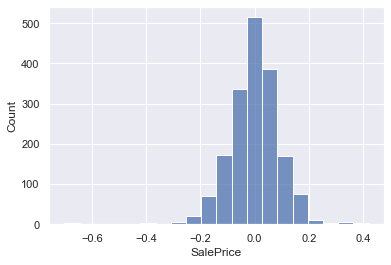

In [22]:
ridge4 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [23]:
model_vars_data.GarageYrBlt.corr(model_vars_data['house_age_'])

-0.8495290774467831

In [25]:
keeps_set = set(to_keep(ridge4,0)) - set(['GarageYrBlt'])
keeps = list(keeps_set)

best params:  {'alpha': 0.01, 'tol': 0.02}
score:  0.9386254128176474
  
test score:  0.9238029787893816
adj_r2:  0.935362735412797
  
adj_r2_test:  0.9136283023665986
 
train RMSE: 0.09351274997447498
  
test RMSE: 0.10287843067274681
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.114274  0.114274
1                                    OverallQual  0.063420  0.063420
2                                yeo_TotalBsmtSF  0.056678  0.056678
3                                     house_age_ -0.052406  0.052406
4                                    OverallCond  0.048168  0.048168
5                                     bc_LotArea  0.045616  0.045616
6                                       2ndFlrSF  0.032706  0.032706
7   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027358  0.027358
8                                   has_basement -0.022906  0.022906
9                                     GarageCond  0.022077  0.022077
10   

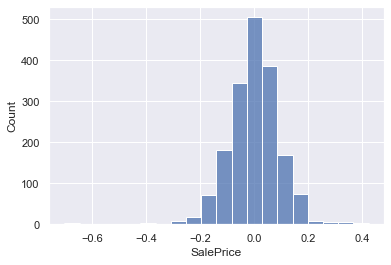

In [26]:
ridge5 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [27]:
keeps =to_keep(ridge5,0.0006)

best params:  {'alpha': 0.01, 'tol': 0.02}
score:  0.9386252724467574
  
test score:  0.9238163634883235
adj_r2:  0.9355149444741122
  
adj_r2_test:  0.9141529523673734
 
train RMSE: 0.09351285691173546
  
test RMSE: 0.10286939451046576
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.114226  0.114226
1                                    OverallQual  0.063425  0.063425
2                                yeo_TotalBsmtSF  0.056733  0.056733
3                                     house_age_ -0.052365  0.052365
4                                    OverallCond  0.048164  0.048164
5                                     bc_LotArea  0.045566  0.045566
6                                       2ndFlrSF  0.032755  0.032755
7   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027378  0.027378
8                                   has_basement -0.022938  0.022938
9                                     GarageCond  0.022064  0.022064
10  

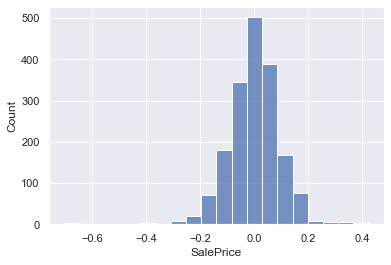

In [28]:
ridge6 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [29]:
keeps =to_keep(ridge5,0.001)

best params:  {'alpha': 0.01, 'tol': 0.02}
score:  0.9386158127722968
  
test score:  0.9239333802516163
adj_r2:  0.9356188201017678
  
adj_r2_test:  0.9146624119122392
 
train RMSE: 0.09352006319302017
  
test RMSE: 0.10279036133471371
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.113874  0.113874
1                                    OverallQual  0.063430  0.063430
2                                yeo_TotalBsmtSF  0.056864  0.056864
3                                     house_age_ -0.052309  0.052309
4                                    OverallCond  0.048286  0.048286
5                                     bc_LotArea  0.045858  0.045858
6                                       2ndFlrSF  0.032817  0.032817
7   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027593  0.027593
8                                   has_basement -0.022949  0.022949
9                                     GarageCond  0.022135  0.022135
10  

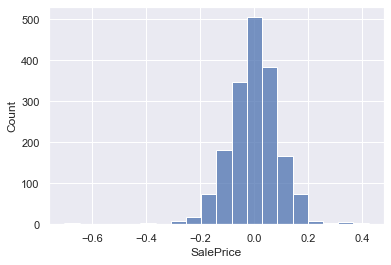

In [30]:
ridge7 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [31]:
keeps = to_keep(ridge7,0.00175)

best params:  {'alpha': 0.01, 'tol': 0.02}
score:  0.9385864091107531
  
test score:  0.9238995966751936
adj_r2:  0.935739182772578
  
adj_r2_test:  0.9151230538099969
 
train RMSE: 0.09354245905088815
  
test RMSE: 0.10281318501577885
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.114236  0.114236
1                                    OverallQual  0.063389  0.063389
2                                yeo_TotalBsmtSF  0.056819  0.056819
3                                     house_age_ -0.052484  0.052484
4                                    OverallCond  0.048203  0.048203
5                                     bc_LotArea  0.045835  0.045835
6                                       2ndFlrSF  0.032530  0.032530
7   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027571  0.027571
8                                   has_basement -0.022843  0.022843
9                                     GarageCond  0.022178  0.022178
10   

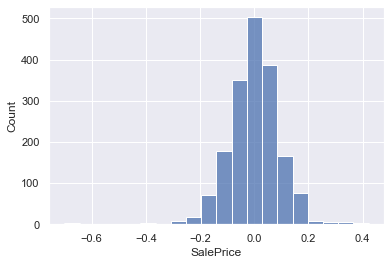

In [32]:
ridge8 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [33]:
keeps = to_keep(ridge8,0.002)

best params:  {'alpha': 0.01, 'tol': 0.02}
score:  0.9385222348906231
  
test score:  0.9242473612944497
adj_r2:  0.9357850877621448
  
adj_r2_test:  0.9158793372513947
 
train RMSE: 0.09359131995346623
  
test RMSE: 0.10257799749801261
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.114186  0.114186
1                                    OverallQual  0.063310  0.063310
2                                yeo_TotalBsmtSF  0.056721  0.056721
3                                     house_age_ -0.052388  0.052388
4                                    OverallCond  0.048379  0.048379
5                                     bc_LotArea  0.045830  0.045830
6                                       2ndFlrSF  0.032561  0.032561
7   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027795  0.027795
8                                   has_basement -0.023044  0.023044
9                                     GarageCond  0.021958  0.021958
10  

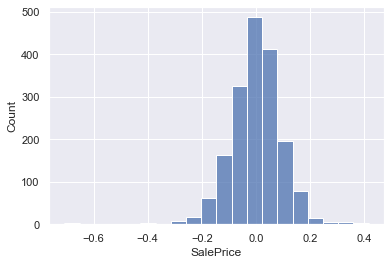

In [34]:
ridge9 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [35]:
keeps =to_keep(ridge9,0.003)

best params:  {'alpha': 0.01, 'tol': 0.02}
score:  0.9384255651542727
  
test score:  0.9240363551199413
adj_r2:  0.9357969489298644
  
adj_r2_test:  0.916011252259964
 
train RMSE: 0.09366487414312273
  
test RMSE: 0.10272076176084258
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.114041  0.114041
1                                    OverallQual  0.063046  0.063046
2                                yeo_TotalBsmtSF  0.056550  0.056550
3                                     house_age_ -0.052393  0.052393
4                                    OverallCond  0.048702  0.048702
5                                     bc_LotArea  0.046242  0.046242
6                                       2ndFlrSF  0.032869  0.032869
7   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027736  0.027736
8                                   has_basement -0.022999  0.022999
9                                     GarageCond  0.022614  0.022614
10   

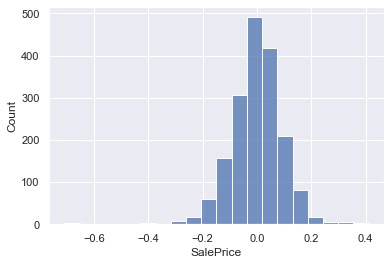

In [36]:
ridge10 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

# Best model ridge 11

In [37]:
keeps =to_keep(ridge10,0.005)

best params:  {'alpha': 0.01, 'tol': 0.02}
score:  0.937890101497473
  
test score:  0.9244224749122313
adj_r2:  0.9354274349679267
  
adj_r2_test:  0.9170384638404377
 
train RMSE: 0.09407125684141361
  
test RMSE: 0.10245936666547259
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.114534  0.114534
1                                    OverallQual  0.062948  0.062948
2                                yeo_TotalBsmtSF  0.056478  0.056478
3                                     house_age_ -0.052975  0.052975
4                                    OverallCond  0.048899  0.048899
5                                     bc_LotArea  0.046251  0.046251
6                                       2ndFlrSF  0.032857  0.032857
7   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027668  0.027668
8                                   has_basement -0.022981  0.022981
9                                     GarageCond  0.022937  0.022937
10   

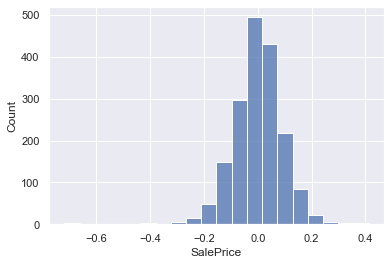

In [38]:
ridge11 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [39]:
keeps = to_keep(ridge11,0.006096)

best params:  {'alpha': 0.01, 'tol': 0.02}
score:  0.9377224914974231
  
test score:  0.9234178874253467
adj_r2:  0.9353285977518377
  
adj_r2_test:  0.9161765988437892
 
train RMSE: 0.09419810184245608
  
test RMSE: 0.10313807117388941
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.115545  0.115545
1                                    OverallQual  0.063512  0.063512
2                                     house_age_ -0.056557  0.056557
3                                yeo_TotalBsmtSF  0.056409  0.056409
4                                    OverallCond  0.049054  0.049054
5                                     bc_LotArea  0.045663  0.045663
6                                       2ndFlrSF  0.032629  0.032629
7   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027226  0.027226
8                                     GarageCond  0.025008  0.025008
9                                   has_basement -0.023053  0.023053
10  

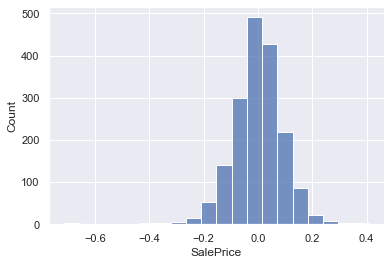

In [40]:
ridge12 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)